In [2]:
import mdtraj as md
import numpy as np

from tqdm import tqdm
from pathlib import Path
import os
from natsort import natsorted
import pandas as pd
from addict import Dict as Adict

import pyemma as pm
import deeptime as dt
from deeptime.markov.msm import MaximumLikelihoodMSM
from deeptime.plots import plot_implied_timescales, plot_energy2d, plot_contour2d_from_xyz
from deeptime.markov.sample import *
from deeptime.util import energy2d

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from objective_func import *

In [ ]:
ftraj_dir = Path('ftraj_egfr')
ftraj_files = natsorted([ftraj for ftraj in ftraj_dir.rglob('run*-clone?_dunbrack.npy')])
len(ftraj_files)

traj_dir = Path('/home/rzhu/stoarge_SRS/trajectories/aws2/')
traj_files = natsorted([ftraj for ftraj in traj_dir.rglob('run*-clone?.h5')])
len(traj_files)

In [3]:
study_name = "markovlag_100ns"
key = 'random_trials'
markov_lag = 100
hp_idx = 60
seed = 42

fig_path = Path(f'plots/{study_name}_{key}_{hp_idx}')
fig_path.mkdir(parents=True, exist_ok=True)

hps = pd.read_hdf(f'data/{study_name}.h5', key='random_trials_hps')
hp_dict = Adict(hps[hps.trial__no == hp_idx].to_dict('records')[0])
hp_dict

{'trial__no': 60,
 'trajlen__cutoff': 1000,
 'tica__lag': 23,
 'tica__dim': 10,
 'tica__stride': 10,
 'cluster__k': 780,
 'cluster__maxiter': 1000,
 'cluster__stride': 100}

In [4]:
ftrajs, traj_mapping = get_data(hp_dict)
ttrajs, tica_mod = tica(hp_dict, ftrajs)
dtrajs, kmeans_mod = kmeans(hp_dict, ttrajs, seed=seed)
msm_mod = MaximumLikelihoodMSM(reversible=True).fit_fetch(dtrajs, lagtime=markov_lag)

Loaded 1983 ftrajs.


/home/rzhu/Loc/miniconda3/envs/kinase/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "tica". Called from /home/rzhu/Loc/miniconda3/envs/kinase/lib/python3.10/site-packages/decorator.py line 232. Use deeptime.decomposition.TICA instead.
  return caller(func, *(extras + args), **kw)
100%|██████████| 1983/1983 [00:04<00:00, 475.68it/s]                        
/home/rzhu/Loc/miniconda3/envs/kinase/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /home/rzhu/Loc/miniconda3/envs/kinase/lib/python3.10/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
100%|██████████| 1000/1000 [00:50<00:00, 19.95it/s] 
/home/rzhu/Loc/miniconda3/envs/kinase/lib/python3.10/site-packages/numpy/core/numeric.py:330: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting=

In [38]:
its_data = its_convergence(dtrajs, lagtimes=[1,10,50,100,200,500,1000])

100%|██████████| 7/7 [1:11:12<00:00, 610.41s/it]


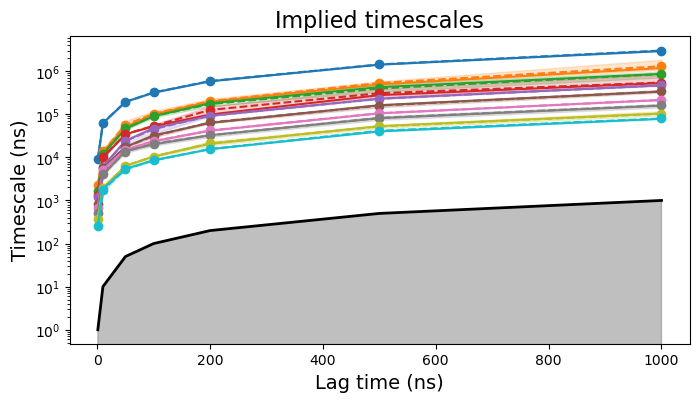

In [40]:
fig, ax = plt.subplots(figsize=(8, 4))
plot_implied_timescales(its_data, n_its=10, ax=ax)
ax.set_yscale('log')
ax.set_title('Implied timescales', fontsize=16)
ax.set_xlabel('Lag time (ns)', fontsize=14)
ax.set_ylabel('Timescale (ns)', fontsize=14)

plt.savefig(fig_path.joinpath('its_test.png'), transparent=True, bbox_inches='tight', dpi=300)
plt.show()

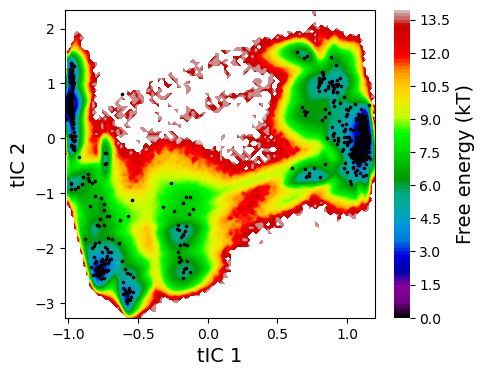

In [105]:
traj_weights = msm_mod.compute_trajectory_weights(dtrajs)
ttraj_cat = np.concatenate(ttrajs, axis=0)

fig, ax = plt.subplots(figsize=(5, 4))
ax, contour, cbar = plot_energy2d(energy2d(ttraj_cat[:,0], ttraj_cat[:,1], weights=np.concatenate(traj_weights,axis=0)), ax=ax, contourf_kws=dict(cmap='nipy_spectral'))
ax.scatter(kmeans_mod.cluster_centers_[:,0], kmeans_mod.cluster_centers_[:,1], s=10, c='black', marker='.')
ax.set_xlabel('tIC 1', fontsize=14)
ax.set_ylabel('tIC 2', fontsize=14)
cbar.ax.set_ylabel('Free energy (kT)', fontsize=14)

plt.savefig(fig_path.joinpath('free_energy.png'), transparent=True, bbox_inches='tight', dpi=300)
plt.show()

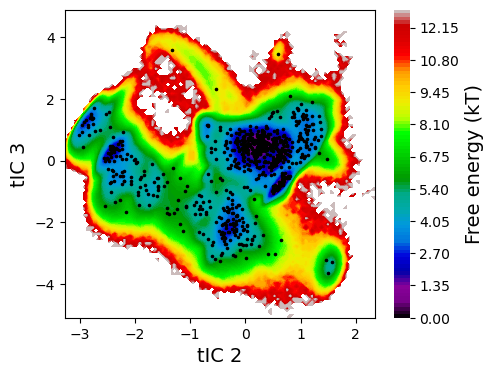

In [60]:
traj_weights = msm_mod.compute_trajectory_weights(dtrajs)
ttraj_cat = np.concatenate(ttrajs, axis=0)

fig, ax = plt.subplots(figsize=(5, 4))
ax, contour, cbar = plot_energy2d(energy2d(ttraj_cat[:,1], ttraj_cat[:,2], weights=np.concatenate(traj_weights,axis=0)), ax=ax, contourf_kws=dict(cmap='nipy_spectral'))
ax.scatter(kmeans_mod.cluster_centers_[:,1], kmeans_mod.cluster_centers_[:,2], s=10, c='black', marker='.')

ax.set_xlabel('tIC 2', fontsize=14)
ax.set_ylabel('tIC 3', fontsize=14)
cbar.ax.set_ylabel('Free energy (kT)', fontsize=14)

#plt.savefig(fig_path.joinpath('free_energy.png'), transparent=True, bbox_inches='tight', dpi=300)
plt.show()

In [5]:
pcca_mod = msm_mod.pcca(4)
pcca_mod.coarse_grained_stationary_probability

array([0.00642877, 0.01075619, 0.44732436, 0.53549068])

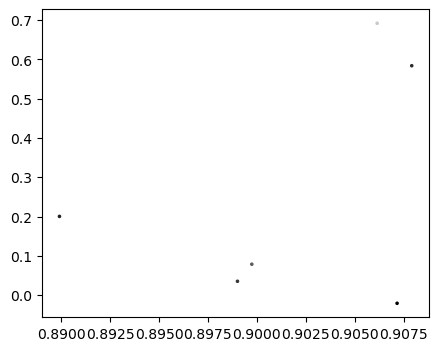

In [101]:
s = 0
fig, ax = plt.subplots(figsize=(5, 4))
ax.scatter(kmeans_mod.cluster_centers_[:,0][pcca_mod.assignments == s], kmeans_mod.cluster_centers_[:,1][pcca_mod.assignments == s], s=10, c=pcca_mod.metastable_distributions[0,:][pcca_mod.assignments == s], marker='.', cmap='grey')

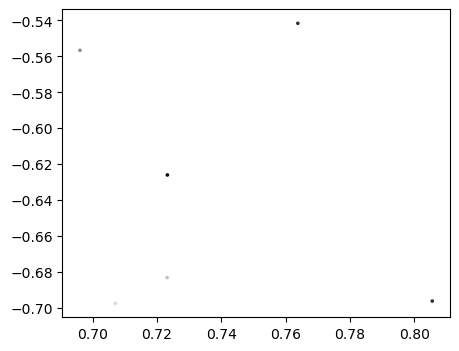

In [102]:
s = 1
fig, ax = plt.subplots(figsize=(5, 4))
ax.scatter(kmeans_mod.cluster_centers_[:,0][pcca_mod.assignments == s], kmeans_mod.cluster_centers_[:,1][pcca_mod.assignments == s], s=10, c=pcca_mod.metastable_distributions[0,:][pcca_mod.assignments == s], marker='.', cmap='grey')

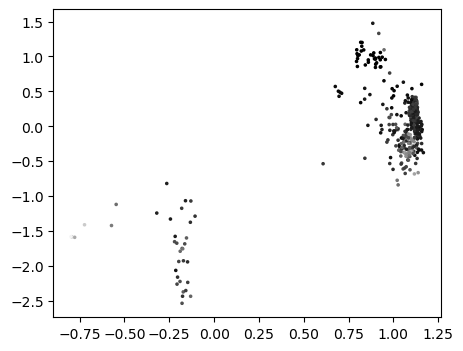

In [103]:
s = 2
fig, ax = plt.subplots(figsize=(5, 4))
ax.scatter(kmeans_mod.cluster_centers_[:,0][pcca_mod.assignments == s], kmeans_mod.cluster_centers_[:,1][pcca_mod.assignments == s], s=10, c=pcca_mod.metastable_distributions[0,:][pcca_mod.assignments == s], marker='.', cmap='grey')

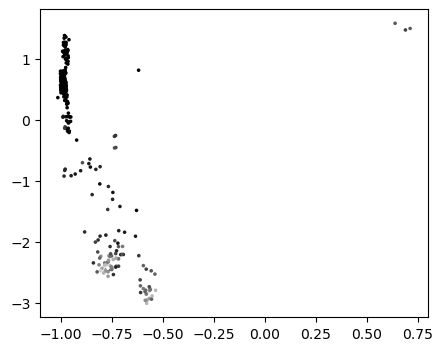

In [104]:
s = 3
fig, ax = plt.subplots(figsize=(5, 4))
ax.scatter(kmeans_mod.cluster_centers_[:,0][pcca_mod.assignments == s], kmeans_mod.cluster_centers_[:,1][pcca_mod.assignments == s], s=10, c=pcca_mod.metastable_distributions[0,:][pcca_mod.assignments == s], marker='.', cmap='grey')

In [6]:
macrostate_to_sample = 2
membership_cutoff = 0.9

memberships = pcca_mod.memberships[:,macrostate_to_sample]
states_to_sample = memberships > membership_cutoff

stationary_distribution = msm_mod.stationary_distribution
stationary_distribution[~states_to_sample] = 0
sample_distribution = stationary_distribution / np.sum(stationary_distribution)

In [7]:
sample_distribution.shape

(780,)

In [11]:
state_matrices = compute_index_states(dtrajs)

In [12]:
def sample_states_by_distribution(microstate_distribution, n_samples) -> List[np.ndarray]:
    state_indices = np.random.choice(len(microstate_distribution), size=n_samples, p=microstate_distribution)
    counts = np.bincount(state_indices)
    state_samples_count = {i:count for i, count in enumerate(counts) if count!=0}
    return state_samples_count

In [13]:
state_samples_count = sample_states_by_distribution(sample_distribution, 10)
state_samples_count

{24: 1, 325: 1, 333: 1, 341: 1, 428: 1, 471: 1, 629: 1, 634: 1, 646: 1, 698: 1}

In [14]:
state_samples_idx = {}
for state, no in state_samples_count.items():
    indicies = np.random.randint(len(state_matrices[state]), size=no)
    state_samples_idx[state] = [state_matrices[state][id,:] for id in indicies]

In [15]:
state_samples_idx

{24: [array([1703, 1868], dtype=int32)],
 325: [array([1747, 2166], dtype=int32)],
 333: [array([ 1019, 10958], dtype=int32)],
 341: [array([ 1085, 16365], dtype=int32)],
 428: [array([1775,  617], dtype=int32)],
 471: [array([ 939, 3873], dtype=int32)],
 629: [array([ 117, 4416], dtype=int32)],
 634: [array([  855, 10295], dtype=int32)],
 646: [array([ 1233, 14471], dtype=int32)],
 698: [array([  689, 14446], dtype=int32)]}

In [16]:
samples = []
for sample in state_samples_idx.values():
    samples.extend(sample)
samples

[array([1703, 1868], dtype=int32),
 array([1747, 2166], dtype=int32),
 array([ 1019, 10958], dtype=int32),
 array([ 1085, 16365], dtype=int32),
 array([1775,  617], dtype=int32),
 array([ 939, 3873], dtype=int32),
 array([ 117, 4416], dtype=int32),
 array([  855, 10295], dtype=int32),
 array([ 1233, 14471], dtype=int32),
 array([  689, 14446], dtype=int32)]

In [19]:
trajs_frames = {}

for sample in samples:
    ftraj_idx, t = sample[0], sample[1]
    ftraj_name = ftraj_files[traj_mapping[ftraj_idx]]
    traj_name = traj_dir.joinpath(ftraj_name.stem.split('_')[0]+'.h5')

    if traj_name in trajs_frames:
        trajs_frames[traj_name].append(t)
    else:
        trajs_frames[traj_name] = [t]

trajs_frames

{PosixPath('/home/rzhu/stoarge_SRS/trajectories/aws2/run343-clone6.h5'): [1868],
 PosixPath('/home/rzhu/stoarge_SRS/trajectories/aws2/run352-clone5.h5'): [2166],
 PosixPath('/home/rzhu/stoarge_SRS/trajectories/aws2/run205-clone8.h5'): [10958],
 PosixPath('/home/rzhu/stoarge_SRS/trajectories/aws2/run219-clone5.h5'): [16365],
 PosixPath('/home/rzhu/stoarge_SRS/trajectories/aws2/run357-clone7.h5'): [617],
 PosixPath('/home/rzhu/stoarge_SRS/trajectories/aws2/run189-clone7.h5'): [3873],
 PosixPath('/home/rzhu/stoarge_SRS/trajectories/aws2/run23-clone8.h5'): [4416],
 PosixPath('/home/rzhu/stoarge_SRS/trajectories/aws2/run172-clone8.h5'): [10295],
 PosixPath('/home/rzhu/stoarge_SRS/trajectories/aws2/run248-clone8.h5'): [14471],
 PosixPath('/home/rzhu/stoarge_SRS/trajectories/aws2/run139-clone7.h5'): [14446]}

In [21]:
trajs_frames = {Path('/home/rzhu/stoarge_SRS/trajectories/aws2/run343-clone6.h5'): [1868,1869],
 Path('/home/rzhu/stoarge_SRS/trajectories/aws2/run352-clone5.h5'): [2166]}

In [22]:
frames = [] 
for traj_name, ind in trajs_frames.items():
    frames.append(md.load(traj_name)[ind])

/home/rzhu/Loc/miniconda3/envs/kinase/lib/python3.10/site-packages/mdtraj/core/trajectory.py:439: UserWarning: top= kwargs ignored since this file parser does not support it
  warnings.warn('top= kwargs ignored since this file parser does not support it')
